In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [230]:
data_copy = pd.read_csv('clean_data.csv')
data_copy.info()

C:\Users\talmo\AppData\Local\Temp\ipykernel_25056\1177339434.py:1: DtypeWarning: Columns (14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data_copy = pd.read_csv('clean_data.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527232 entries, 0 to 527231
Data columns (total 41 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   Origin                             527232 non-null  object
 1   Destination                        527232 non-null  object
 2   TTT                                527232 non-null  int64 
 3   LOS                                527232 non-null  int64 
 4   Arrival Time                       527232 non-null  object
 5   Return Arrival Time                527232 non-null  object
 6   Onward Departure Airport           527232 non-null  object
 7   Onward Arrival Airport             527232 non-null  object
 8   Return Departure Airport           527232 non-null  object
 9   Return Arrival Airport             527232 non-null  object
 10  Onward Airlines                    527232 non-null  object
 11  Return Airlines                    527232 non-null  

In [231]:
# Convert the 'Site' column into dummy variables (One-Hot Encoding)
# This transformation creates separate columns for each category (Kayak and Momondo),
# ensuring that the model does not treat the site as a numerical feature.
data_copy = pd.get_dummies(data_copy, columns=['Site'], prefix='Site')

print(data_copy[['Site_Kayak', 'Site_Momondo']].head())  

   Site_Kayak  Site_Momondo
0        True         False
1        True         False
2        True         False
3        True         False
4        True         False


## One-Hot Encoding for the 'Site' Column

The `Site` column represents the website from which data was collected (e.g., Kayak, Momondo). Since machine learning models cannot process categorical variables directly, we apply **One-Hot Encoding** to convert this column into separate binary columns (`Site_Kayak`, `Site_Momondo`).

Keeping the `Site` column as a numeric variable would incorrectly imply an ordinal relationship between sites. One-Hot Encoding ensures the model treats each site as an independent feature, preventing unintended biases and allowing it to capture potential differences in price variations between websites.

__________

In [232]:
# חישוב מחיר ממוצע לכל מסלול (מוצא-יעד) לפי אתר
avg_prices = data_copy.groupby(["Origin", "Destination"])["Price(NIS)"].mean().reset_index()

# יצירת טבלת Pivot שמשווה את המחיר הממוצע בין האתרים עבור כל מסלול
pivot_prices = data_copy.pivot_table(index=["Origin", "Destination"], 
                                     values="Price(NIS)", 
                                     columns=["Site_Kayak"], 
                                     aggfunc="mean")

# שינוי שמות העמודות כך שכל אתר יקבל שם ברור
pivot_prices.columns = ["Momondo Price" if col == 0 else "Kayak Price" for col in pivot_prices.columns]

# חישוב הפרש המחירים בין האתרים, אם יש נתונים עבור שניהם
if "Kayak Price" in pivot_prices.columns and "Momondo Price" in pivot_prices.columns:
    pivot_prices["Price Diff"] = pivot_prices["Kayak Price"] - pivot_prices["Momondo Price"]

# איפוס האינדקס להצגת הטבלה בצורה מסודרת
pivot_prices.reset_index(inplace=True)

# הצגת הטבלה לאחר העיבוד כדי לוודא שהתהליך בוצע כראוי
print(pivot_prices.head())


   Origin Destination  Momondo Price  Kayak Price  Price Diff
0  London       Paris     432.808814   416.972133  -15.836681
1  London        Rome     684.678102   655.423119  -29.254983
2   Paris      London     433.616678   415.122300  -18.494378
3   Paris        Rome     700.960781   651.763991  -49.196790
4    Rome      London     702.721535   665.486588  -37.234947


## 🛫 Flight Price Comparison - Summary

- **Kayak prices are consistently lower** than Momondo across all routes.
- The largest price difference is on the **Paris → Rome** route (~49 NIS).
- The smallest price difference is on the **London → Paris** route (~15 NIS).
- **Possible reasons**:  
  - Different pricing algorithms between the platforms.  
  - Variations in demand and supply dynamics.  
  - Exclusive airline deals or promotions.  
  - Time-based fluctuations in fare updates.

In [233]:
print(data_copy.columns)

Index(['Origin', 'Destination', 'TTT', 'LOS', 'Arrival Time',
       'Return Arrival Time', 'Onward Departure Airport',
       'Onward Arrival Airport', 'Return Departure Airport',
       'Return Arrival Airport', 'Onward Airlines', 'Return Airlines',
       'Onward Flight Connections', 'Onward Connection Duration(min)',
       'Onward Flight Connection Airport', 'Return Flight Connections',
       'Return Connection Duration(min)', 'Return Flight Connection Airport',
       'Carry-ons', 'Checked Bags', 'Price(NIS)', 'Snapshot Date',
       'Total Onward Flight Duration(min)',
       'Total Return Flight Duration(min)', 'Departure Month', 'Departure Day',
       'Departure Weekday', 'Return Month', 'Return Day', 'Return Weekday',
       'Departure Time Category Num', 'Return Time Category Num',
       'Is Weekend Flight', 'Onward Departure Airport Distance',
       'Onward Arrival Airport Distance', 'Return Departure Airport Distance',
       'Return Arrival Airport Distance', 'Total C

# Exploratory Data Analysis (EDA)

In this section, we visualize key variables and examine their impact on price.  
We will explore trends, distributions, and relationships between features to gain insights into pricing patterns.


In [234]:
# Calculate price difference per site, considering only relevant values for each site
data_copy["Price Diff"] = np.where(data_copy["Site_Kayak"] == 1, 
                                   data_copy["Price(NIS)"], 0) - np.where(data_copy["Site_Momondo"] == 1, 
                                                                           data_copy["Price(NIS)"], 0)

# Select only numeric columns for correlation analysis
numeric_data = data_copy.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Sort correlations based on 'Price Diff' (keeping direction)
price_diff_corr = correlation_matrix["Price Diff"].sort_values(ascending=False)

# Retrieve the top 15 features with the highest correlation (both positive and negative)
top_features = price_diff_corr.head(15)

# Print the results
print("Top correlated features with Price Diff (with direction):")
print(top_features)


Top correlated features with Price Diff (with direction):
Price Diff                           1.000000
Return Departure Airport Distance    0.024748
Onward Arrival Airport Distance      0.022421
Onward Departure Airport Distance    0.020705
Return Arrival Airport Distance      0.016583
Return Weekday                       0.002742
Return Day                          -0.000445
LOS                                 -0.000455
Departure Month                     -0.000720
Departure Weekday                   -0.001879
Return Month                        -0.002243
Departure Day                       -0.002984
TTT                                 -0.005289
Onward Connection Duration(min)     -0.005588
Return Connection Duration(min)     -0.006869
Name: Price Diff, dtype: float64


## Price Differences Between Kayak and Momondo

### **Top Correlated Features with Price Diff (with direction)**
| Feature                              | Correlation |
|--------------------------------------|------------|
| Price Diff                           | **1.000**  |
| Return Departure Airport Distance    | **+0.0247** |
| Onward Arrival Airport Distance      | **+0.0224** |
| Onward Departure Airport Distance    | **+0.0207** |
| Return Arrival Airport Distance      | **+0.0165** |
| Return Weekday                       | **+0.0027** |
| Return Day                           | **-0.0004** |
| LOS (Length of Stay)                 | **-0.0004** |
| Departure Month                      | **-0.0007** |
| Departure Weekday                    | **-0.0018** |
| Return Month                         | **-0.0022** |
| Departure Day                        | **-0.0029** |
| TTT (Total Travel Time)              | **-0.0052** |
| Onward Connection Duration (min)     | **-0.0055** |
| Return Connection Duration (min)     | **-0.0068** |

- **Airport distances have the highest correlation** with price differences, though the effect is small.
- **Day of travel (weekdays and months) has a minimal impact** on price variations.
- **Total travel time and connection durations have a slight negative correlation**, suggesting longer layovers may slightly reduce the price difference.
- The correlations are **relatively weak**, indicating that **price differences are likely influenced by additional external factors not captured in the dataset**.
_____________

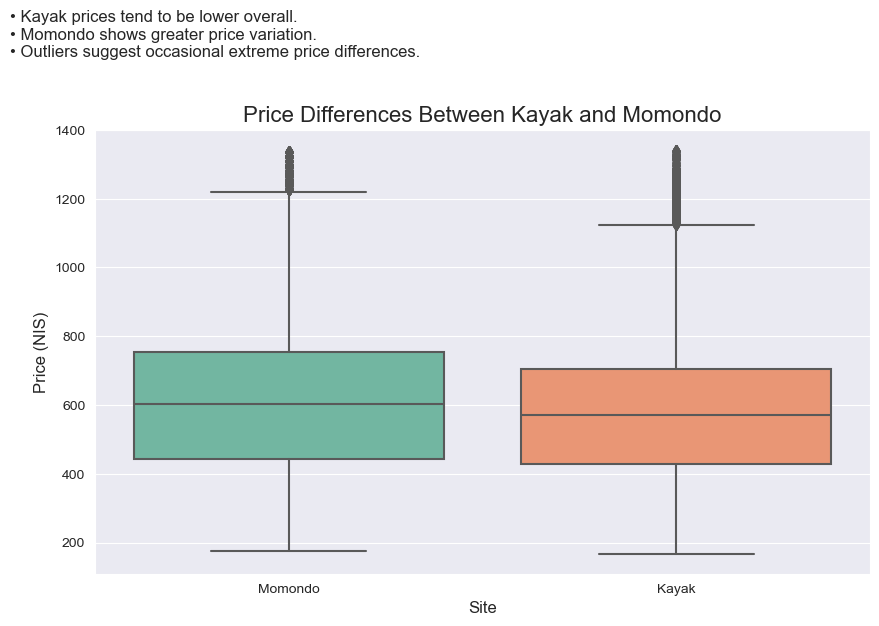

In [235]:
#visualize price differences between Kayak and Momondo
plt.figure(figsize=(10, 6))
sns.boxplot(x="Site_Kayak", y="Price(NIS)", data=data_copy, palette="Set2")


plt.title("Price Differences Between Kayak and Momondo", fontsize=16)
plt.xlabel("Site", fontsize=12)
plt.ylabel("Price (NIS)", fontsize=12)

# Update x-axis labels to display site names instead of numerical values
plt.xticks([0, 1], ['Momondo', 'Kayak'])

# Add conclusions above the title
conclusions = (
    "• Kayak prices tend to be lower overall.\n"
    "• Momondo shows greater price variation.\n"
    "• Outliers suggest occasional extreme price differences."
)

# Add the conclusions as text inside the plot
plt.subplots_adjust(top=0.85)  # Adjust the figure to make space for the text
plt.figtext(0.04, 1.05, conclusions, fontsize=12, ha='left', va='top')
plt.show()



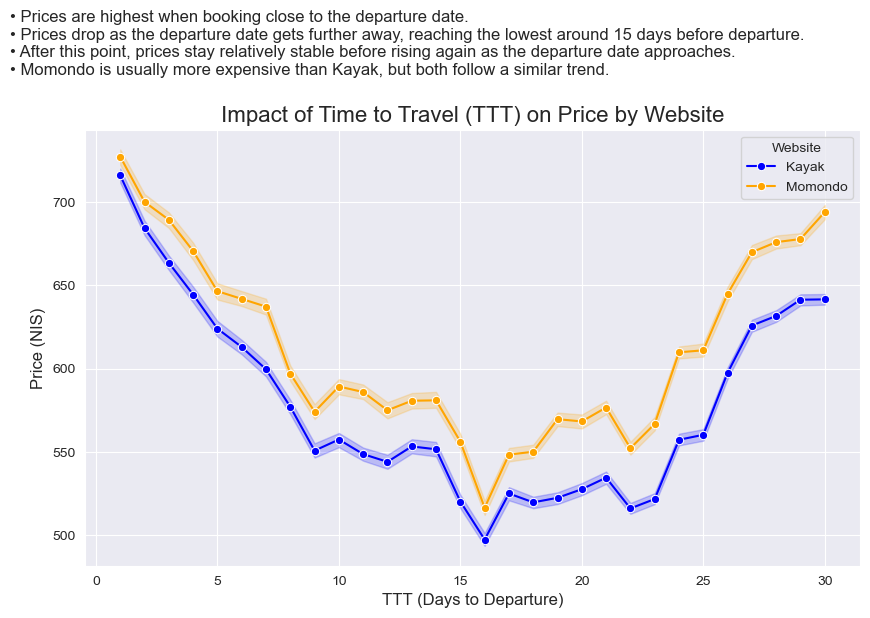

In [236]:
# Set figure size
plt.figure(figsize=(10, 4))

# Line plot: Average prices for each TTT value, separated by website
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], x="TTT", y="Price(NIS)", 
             label="Kayak", marker="o", color="blue")  # Kayak = Blue

sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], x="TTT", y="Price(NIS)", 
             label="Momondo", marker="o", color="orange")  # Momondo = Orange

# Add conclusions above the title
conclusions = (
    "• Prices are highest when booking close to the departure date.\n"
    "• Prices drop as the departure date gets further away, reaching the lowest around 15 days before departure.\n"
    "• After this point, prices stay relatively stable before rising again as the departure date approaches.\n"
    "• Momondo is usually more expensive than Kayak, but both follow a similar trend."
)

# Adjust the figure layout to accommodate the text
plt.subplots_adjust(top=1.2)  
plt.figtext(0.05, 1.50, conclusions, fontsize=12, ha='left', va='top')

# Graph styling
plt.title("Impact of Time to Travel (TTT) on Price by Website", fontsize=16)
plt.xlabel("TTT (Days to Departure)", fontsize=12)
plt.ylabel("Price (NIS)", fontsize=12)

# Update legend for clarity
plt.legend(title="Website")

# Display the plot
plt.show()


In [237]:
# Calculate the total flight duration (in minutes) for the entire round-trip journey
# This is done by summing up:
# - Total duration of the onward flight
# - Duration of onward flight connections (layovers)
# - Total duration of the return flight
# - Duration of return flight connections (layovers)
data_copy["Total Flight Duration (min)"] = (
    data_copy["Total Onward Flight Duration(min)"] + 
    data_copy["Onward Connection Duration(min)"] + 
    data_copy["Total Return Flight Duration(min)"] + 
    data_copy["Return Connection Duration(min)"]
)

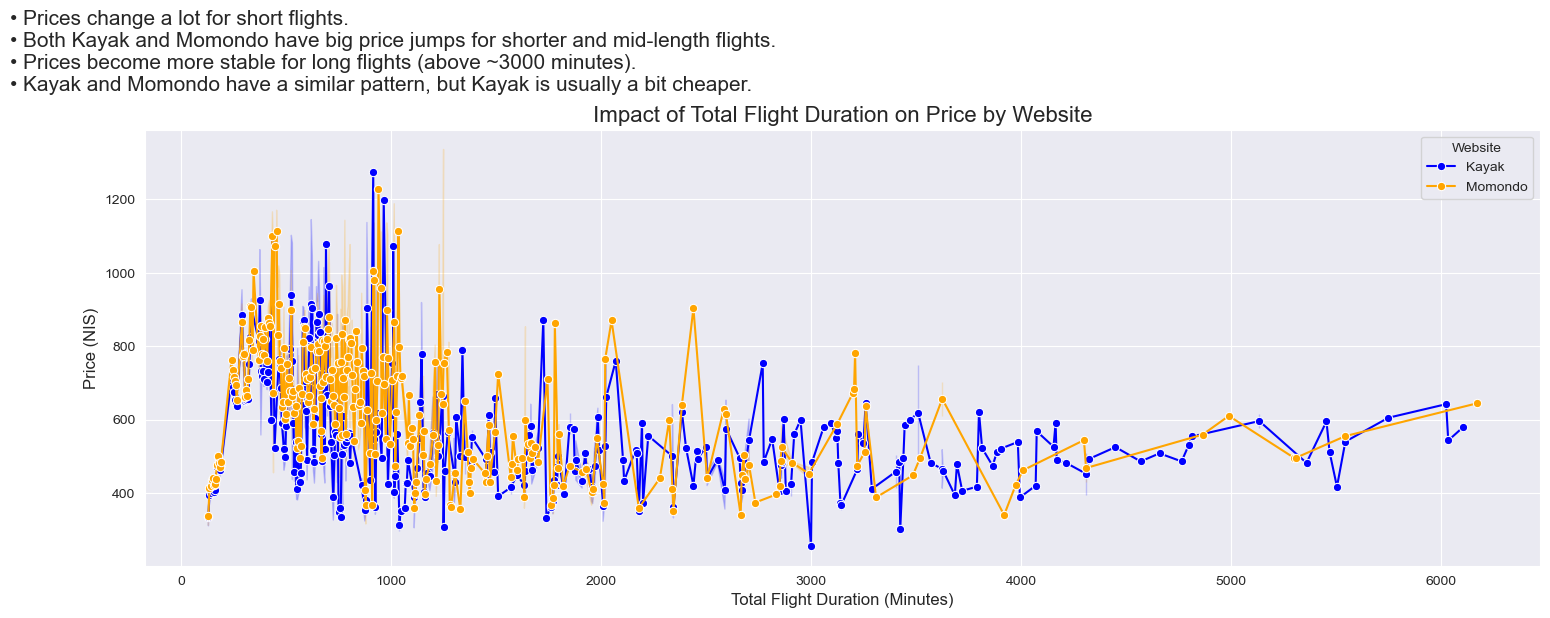

In [238]:
# Set figure size
plt.figure(figsize=(18, 4))

# Line plot: Average prices for each total flight duration value, separated by website
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], x="Total Flight Duration (min)", 
             y="Price(NIS)", label="Kayak", marker="o", color="blue")  # Kayak = Blue

sns.lineplot(data=data_copy[data_copy["Site_Momondo"] == 1], x="Total Flight Duration (min)", 
             y="Price(NIS)", label="Momondo", marker="o", color="orange")  # Momondo = Orange

# Graph styling
plt.title("Impact of Total Flight Duration on Price by Website", fontsize=16)
plt.xlabel("Total Flight Duration (Minutes)", fontsize=12)
plt.ylabel("Price (NIS)", fontsize=12)

# Update the legend for better readability
plt.legend(title="Website")

# Add conclusions above the title
conclusions = (
    "• Prices change a lot for short flights.\n"
    "• Both Kayak and Momondo have big price jumps for shorter and mid-length flights.\n"
    "• Prices become more stable for long flights (above ~3000 minutes).\n"
    "• Kayak and Momondo have a similar pattern, but Kayak is usually a bit cheaper."
)

# Adjust the figure to make space for the text and place the text at the left side
plt.subplots_adjust(top=1.2)  
plt.figtext(0.05, 1.5, conclusions, fontsize=15, ha='left', va='top')

# Display the plot
plt.show()

In [ ]:
# Compute descriptive statistics for both websites in a single step
price_stats = data_copy.groupby("Site_Kayak")["Price(NIS)"].describe().T.round(2)

# Rename columns for clarity (0 = Momondo, 1 = Kayak)
price_stats.columns = ["Momondo", "Kayak"]

# Display the stats
display(price_stats)

,Momondo,Kayak
count,261896.00,265336.00
mean,611.50,578.10
std,215.52,197.59
min,174.00,168.00
25%,444.00,427.00
50%,603.00,571.00
75%,755.00,706.00
max,1339.00,1342.00


## Handling Data Imbalance Between Kayak and Momondo  
The dataset contains slightly more flights from **Kayak** than from **Momondo**.  
This could potentially impact our price difference prediction model if one site is overrepresented.  

### ** Should We Balance the Data?**  
Since the difference in flight counts is not very large, we will not modify the dataset for now.  
However, we need to check if this imbalance affects model performance before deciding on further steps.  
_______________________________

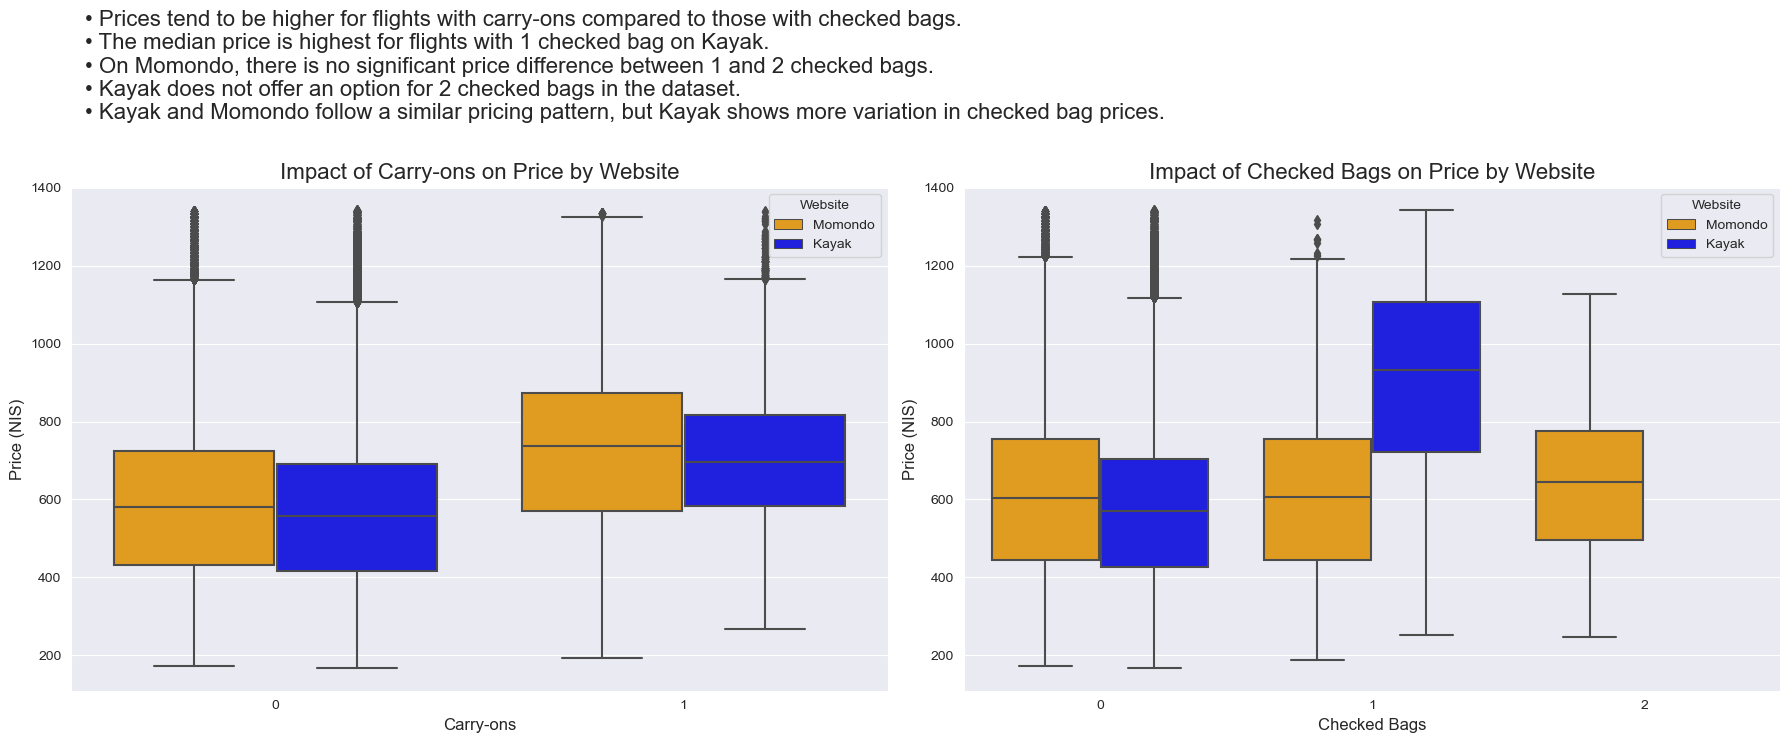

In [240]:
# Convert NaN values to 0 and change data type to integer
data_copy["Carry-ons"] = data_copy["Carry-ons"].fillna(0).astype(int)
data_copy["Checked Bags"] = data_copy["Checked Bags"].fillna(0).astype(int)

# Define colors for consistency in the legend
palette = {"Kayak": "blue", "Momondo": "orange"}

# Set figure size with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot for Carry-ons impact on price by website
sns.boxplot(data=data_copy, x="Carry-ons", y="Price(NIS)", hue="Site_Kayak", 
            palette={1: palette["Kayak"], 0: palette["Momondo"]}, ax=axes[0])

# Styling for Carry-ons plot
axes[0].set_title("Impact of Carry-ons on Price by Website", fontsize=16)
axes[0].set_xlabel("Carry-ons", fontsize=12)
axes[0].set_ylabel("Price (NIS)", fontsize=12)

# Fix legend colors
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ["Momondo", "Kayak"], title="Website")

# Boxplot for Checked Bags impact on price by website
sns.boxplot(data=data_copy, x="Checked Bags", y="Price(NIS)", hue="Site_Kayak", 
            palette={1: palette["Kayak"], 0: palette["Momondo"]}, ax=axes[1])

# Styling for Checked Bags plot
axes[1].set_title("Impact of Checked Bags on Price by Website", fontsize=16)
axes[1].set_xlabel("Checked Bags", fontsize=12)
axes[1].set_ylabel("Price (NIS)", fontsize=12)

# Fix legend colors
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, ["Momondo", "Kayak"], title="Website")

# Add conclusions above the title
conclusions = (
    "• Prices tend to be higher for flights with carry-ons compared to those with checked bags.\n"
    "• The median price is highest for flights with 1 checked bag on Kayak.\n"
    "• On Momondo, there is no significant price difference between 1 and 2 checked bags.\n"
    "• Kayak does not offer an option for 2 checked bags in the dataset.\n"
    "• Kayak and Momondo follow a similar pricing pattern, but Kayak shows more variation in checked bag prices."
)

plt.subplots_adjust(top=1.3)
plt.figtext(0.05, 1.23, conclusions, fontsize=16, ha='left', va='top')

plt.tight_layout()
plt.show()


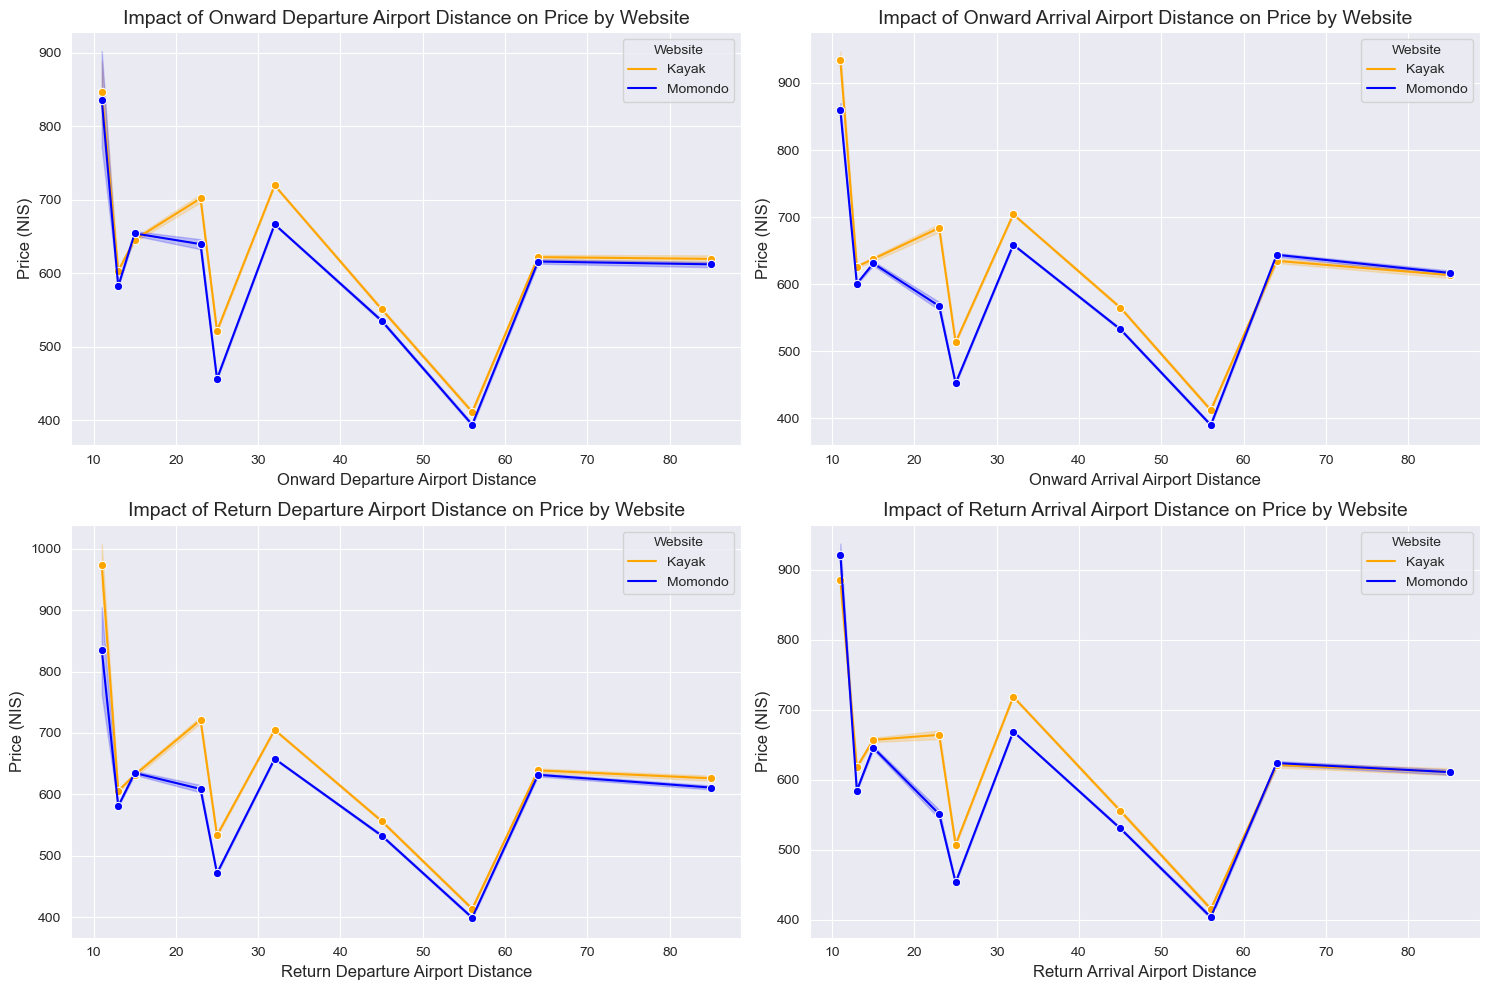

In [241]:
# Set up subplots for the distance columns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Define the distance columns
distance_columns = [
    "Onward Departure Airport Distance",
    "Onward Arrival Airport Distance",
    "Return Departure Airport Distance",
    "Return Arrival Airport Distance"
]

# Define colors for consistency
colors = {1: "blue", 0: "orange"}

# Iterate over distance columns and create plots
for ax, col in zip(axes.flat, distance_columns):
    sns.lineplot(data=data_copy, x=col, y="Price(NIS)", hue="Site_Kayak", 
                 palette=colors, marker="o", ax=ax)

    # Styling
    ax.set_title(f"Impact of {col} on Price by Website", fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Price (NIS)", fontsize=12)

    # Fix legend colors manually
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["Kayak", "Momondo"], title="Website")

plt.tight_layout()
plt.show()


## Impact of Airport Distance on Flight Prices

**Main Observations**
- Prices **change a lot** when the airport is **closer** (10-30 km).
- There is a **big drop** in prices around 50 km.
- Prices **stay more stable** for flights departing from airports 60 km or farther.
- **Kayak and Momondo show similar trends**, but Kayak has **slightly higher peaks**.
- After **60 km**, distance **doesn't seem to affect price much**.

**Why does this happen?**
- **Shorter flights** might cost more because of **higher demand or airport fees**.
- The **drop at 50 km** could mean airlines change their pricing rules at this distance.
- For **longer distances**, other factors (like demand and airline policies) may be more important than distance.

_________________

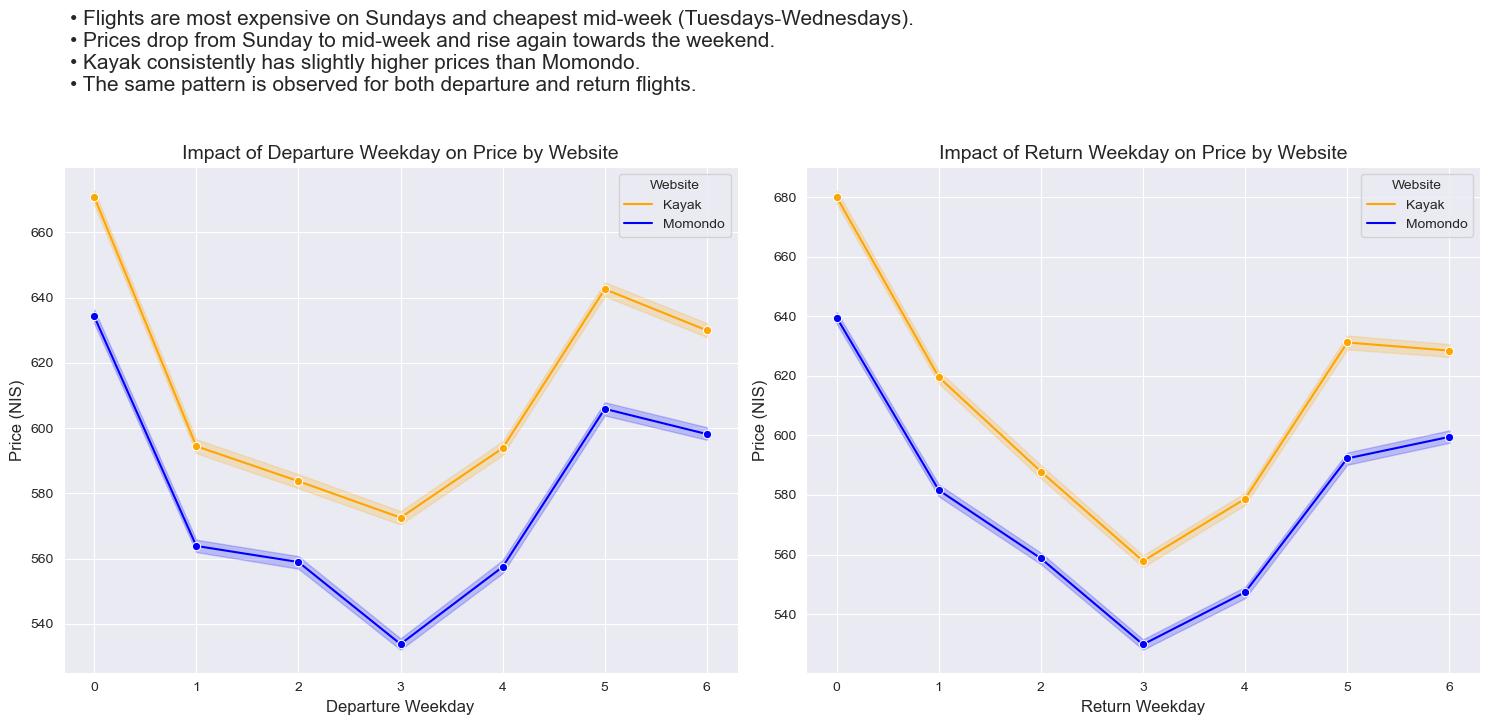

In [242]:
# Set up subplots for Departure and Return Weekdays
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Define the weekday columns
weekday_columns = ["Departure Weekday", "Return Weekday"]

# Define colors for consistency
colors = {1: "blue", 0: "orange"}

# Iterate over the weekday columns and create plots
for ax, col in zip(axes, weekday_columns):
    sns.lineplot(data=data_copy, x=col, y="Price(NIS)", hue="Site_Kayak", 
                 palette=colors, marker="o", ax=ax)

    
    ax.set_title(f"Impact of {col} on Price by Website", fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Price (NIS)", fontsize=12)

    # Fix legend colors manually
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["Kayak", "Momondo"], title="Website")

conclusions = (
    "• Flights are most expensive on Sundays and cheapest mid-week (Tuesdays-Wednesdays).\n"
    "• Prices drop from Sunday to mid-week and rise again towards the weekend.\n"
    "• Kayak consistently has slightly higher prices than Momondo.\n"
    "• The same pattern is observed for both departure and return flights."
)

# Adjust layout to make space for text
plt.subplots_adjust(top=1.3)
plt.figtext(0.05, 1.2, conclusions, fontsize=15, ha='left', va='top')

# Display the plots
plt.tight_layout()
plt.show()


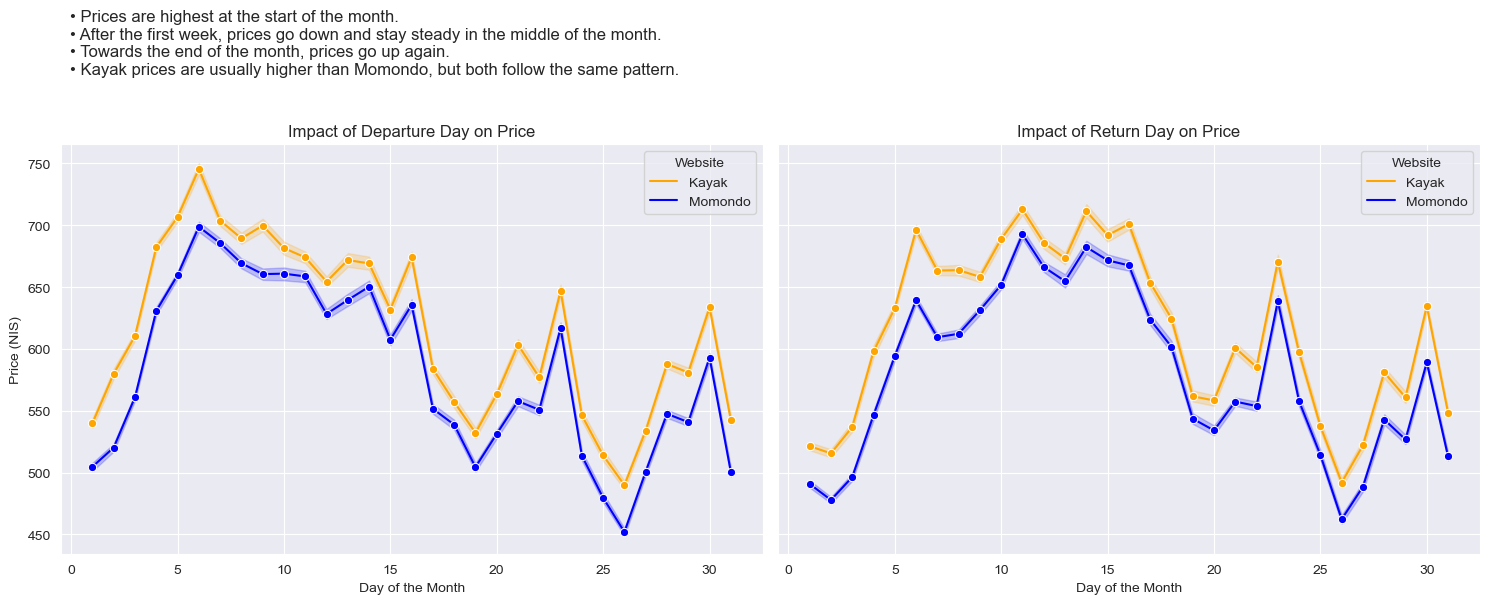

In [243]:
# List of variables to display
day_columns = ["Departure Day", "Return Day"]

# Create a figure with 2 subplots to show the impact of departure and return day on price
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Titles for the subplots
titles = ["Impact of Departure Day on Price", "Impact of Return Day on Price"]

# Define colors for each website
colors = {1: "blue", 0: "orange"}

# Generate each subplot
for ax, col, title in zip(axes, day_columns, titles):
    sns.lineplot(data=data_copy, x=col, y="Price(NIS)", hue="Site_Kayak", 
                 palette=colors, marker="o", ax=ax)

    ax.set_title(title)
    ax.set_xlabel("Day of the Month")

    # Fix legend: Change labels from True/False to Kayak/Momondo
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["Kayak", "Momondo"], title="Website")

# Add a shared Y-label
axes[0].set_ylabel("Price (NIS)")

# Add conclusions above the plots
conclusions = (
    "• Prices are highest at the start of the month.\n"
    "• After the first week, prices go down and stay steady in the middle of the month.\n"
    "• Towards the end of the month, prices go up again.\n"
    "• Kayak prices are usually higher than Momondo, but both follow the same pattern."
)

# Adjust layout to make space for conclusions
plt.subplots_adjust(top=1.3)
plt.figtext(0.05, 1.2, conclusions, fontsize=12, ha='left', va='top')

# Display the plots
plt.tight_layout()
plt.show()


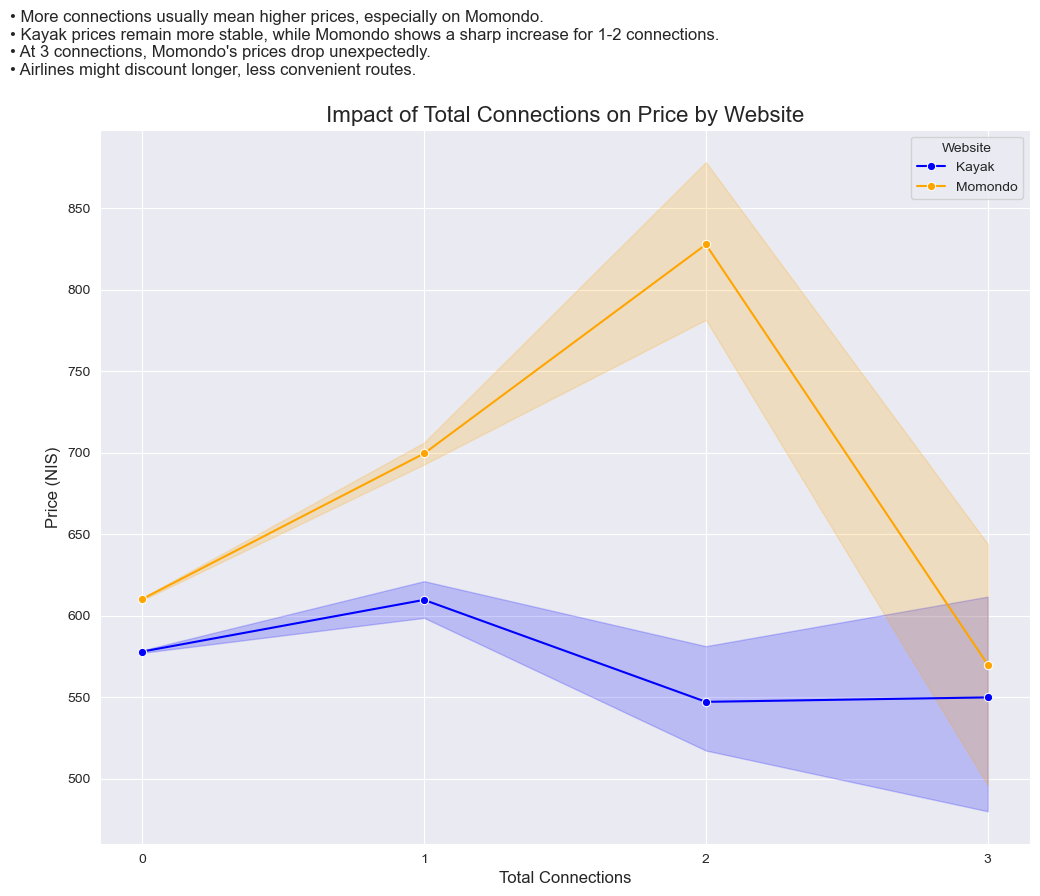

In [244]:
# Set figure size for the Total Connections plot
plt.figure(figsize=(12, 6))

# Line plot for Kayak based on the Total Connections column
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="Total Connections", y="Price(NIS)", label="Kayak", marker="o", color="blue")

# Line plot for Momondo based on the Total Connections column
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="Total Connections", y="Price(NIS)", label="Momondo", marker="o", color="orange")

# Ensure x-axis only shows whole numbers (no decimals)
plt.xticks(np.arange(0, data_copy["Total Connections"].max() + 1, 1))

# Add conclusions above the title
conclusions = (
    "• More connections usually mean higher prices, especially on Momondo.\n"
    "• Kayak prices remain more stable, while Momondo shows a sharp increase for 1-2 connections.\n"
    "• At 3 connections, Momondo's prices drop unexpectedly.\n"
    "• Airlines might discount longer, less convenient routes."
)

# Adjust layout for text placement
plt.subplots_adjust(top=1.3)
plt.figtext(0.05, 1.5, conclusions, fontsize=12, ha='left', va='top')

# Styling
plt.title("Impact of Total Connections on Price by Website", fontsize=16)
plt.xlabel("Total Connections", fontsize=12)
plt.ylabel("Price (NIS)", fontsize=12)
plt.legend(title="Website")

plt.show()


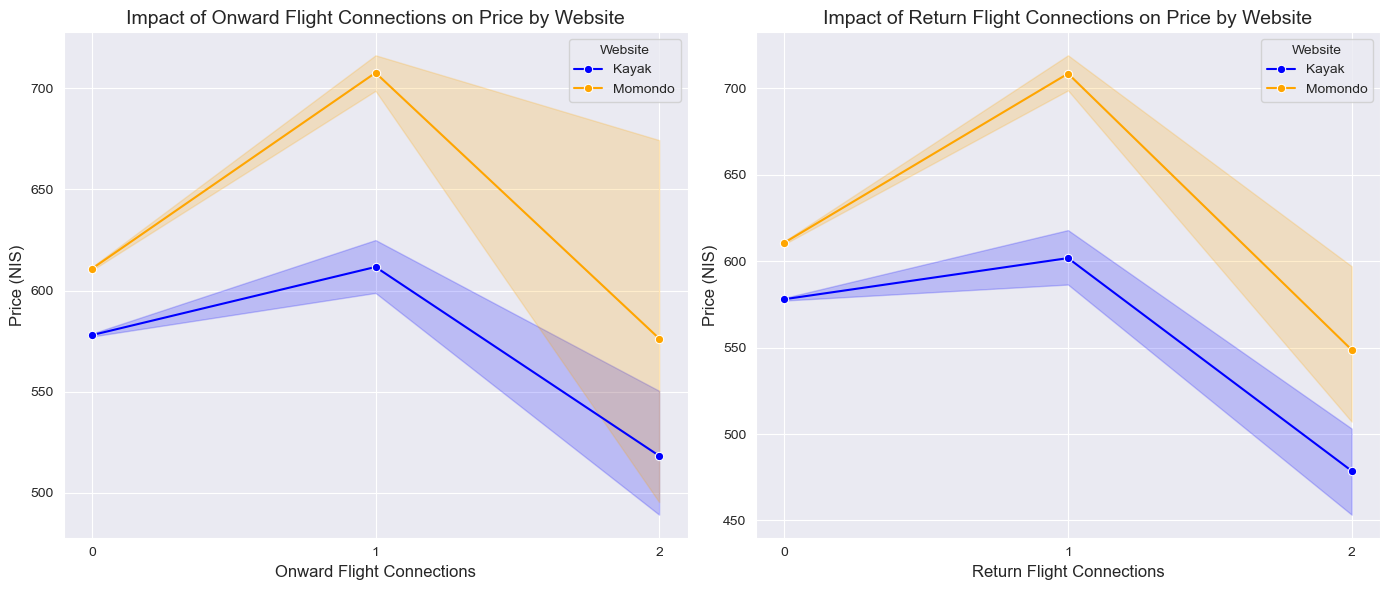

In [245]:
# figure with two subplots (for Onward and Return Flight Connections)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Onward Flight Connections plot for Kayak and Momondo
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="Onward Flight Connections", y="Price(NIS)", 
             label="Kayak", marker="o", color="blue", ax=axes[0])
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="Onward Flight Connections", y="Price(NIS)", 
             label="Momondo", marker="o", color="orange", ax=axes[0])

# Return Flight Connections plot for Kayak and Momondo
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="Return Flight Connections", y="Price(NIS)", 
             label="Kayak", marker="o", color="blue", ax=axes[1])
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="Return Flight Connections", y="Price(NIS)", 
             label="Momondo", marker="o", color="orange", ax=axes[1])

axes[0].set_title("Impact of Onward Flight Connections on Price by Website", fontsize=14)
axes[0].set_xlabel("Onward Flight Connections", fontsize=12)
axes[0].set_ylabel("Price (NIS)", fontsize=12)
axes[0].legend(title="Website")

axes[1].set_title("Impact of Return Flight Connections on Price by Website", fontsize=14)
axes[1].set_xlabel("Return Flight Connections", fontsize=12)
axes[1].set_ylabel("Price (NIS)", fontsize=12)
axes[1].legend(title="Website")

# Ensure X-axis displays only whole numbers (0, 1, 2)
axes[0].set_xticks([0, 1, 2])
axes[1].set_xticks([0, 1, 2])

plt.tight_layout()
plt.show()


In [246]:
data_copy[['Onward Flight Connections', 'Return Flight Connections']].describe()

,Onward Flight Connections,Return Flight Connections
count,527232.000000,527232.000000
mean,0.005127,0.005280
std,0.072079,0.073488
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,2.000000,2.000000


## Flight Connections & Price

- Prices rise with 1 connection but drop at 2 connections.  
- **No difference** between onward & return flights—same trend.  
- **Momondo is always pricier** than Kayak.  
- Most flights have 0 or 1 connection, keeping trends identical.  
- Low demand or small sample size may explain the 2-stop price drop.  
_______

In [247]:
data_copy.columns

Index(['Origin', 'Destination', 'TTT', 'LOS', 'Arrival Time',
       'Return Arrival Time', 'Onward Departure Airport',
       'Onward Arrival Airport', 'Return Departure Airport',
       'Return Arrival Airport', 'Onward Airlines', 'Return Airlines',
       'Onward Flight Connections', 'Onward Connection Duration(min)',
       'Onward Flight Connection Airport', 'Return Flight Connections',
       'Return Connection Duration(min)', 'Return Flight Connection Airport',
       'Carry-ons', 'Checked Bags', 'Price(NIS)', 'Snapshot Date',
       'Total Onward Flight Duration(min)',
       'Total Return Flight Duration(min)', 'Departure Month', 'Departure Day',
       'Departure Weekday', 'Return Month', 'Return Day', 'Return Weekday',
       'Departure Time Category Num', 'Return Time Category Num',
       'Is Weekend Flight', 'Onward Departure Airport Distance',
       'Onward Arrival Airport Distance', 'Return Departure Airport Distance',
       'Return Arrival Airport Distance', 'Total C

In [248]:
# Count the number of flights per route per website
route_counts = data_copy.groupby(["Origin", "Destination", "Site_Kayak"]).size().reset_index(name="Flight Count")

# Convert True/False to actual site names
route_counts["Site"] = route_counts["Site_Kayak"].map({True: "Kayak", False: "Momondo"})

# Pivot table to display flights per route for each website
route_counts_pivot = route_counts.pivot_table(index=["Origin", "Destination"], 
                                              columns="Site", 
                                              values="Flight Count", 
                                              aggfunc="sum").fillna(0)

# Reset index for a cleaner display
route_counts_pivot.reset_index(inplace=True)

# Display the table
display(route_counts_pivot)


Site,Origin,Destination,Kayak,Momondo
0,London,Paris,43815,43272
1,London,Rome,43678,43113
2,Paris,London,44399,43890
3,Paris,Rome,44939,44290
4,Rome,London,43840,43492
5,Rome,Paris,44665,43839


## Flight Counts per Route and Website

- Kayak and Momondo have a similar number of flights for each route, with slight variations.
- The busiest route is Paris - Rome, having the highest flight count.
- London - Paris and London - Rome are also popular routes, showing high flight frequencies.
- No significant dominance of one website over another in terms of flight availability.


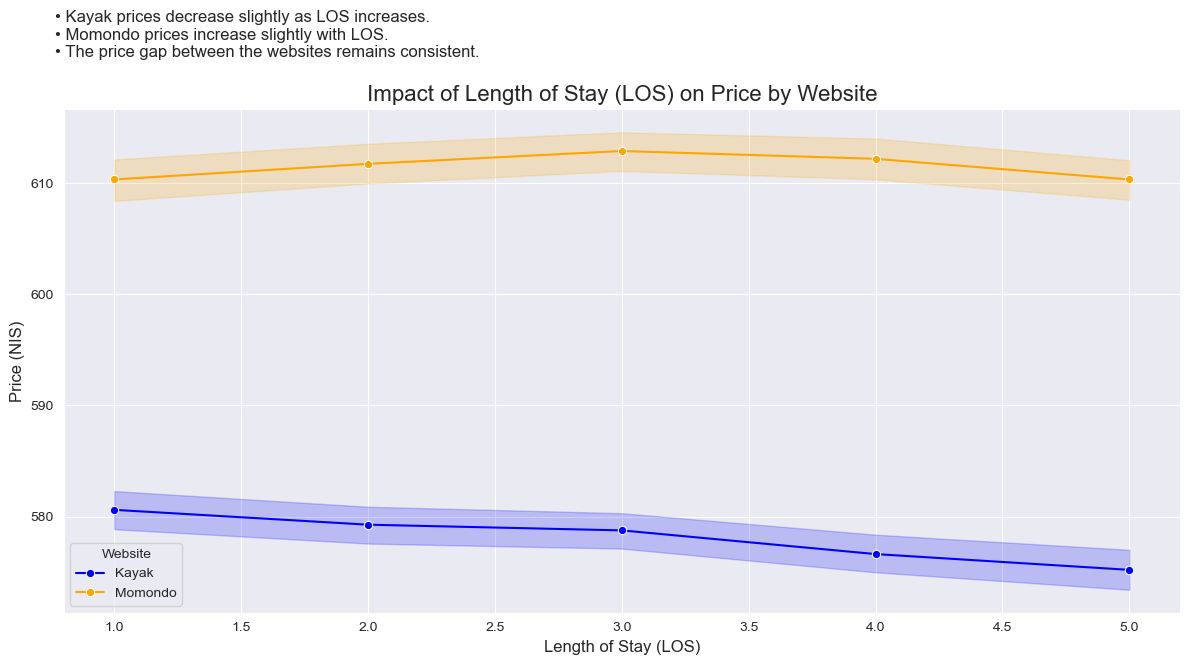

In [249]:
# LOS plot
plt.figure(figsize=(12, 6))

# Line plot for Kayak based on the LOS column
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="LOS", y="Price(NIS)", label="Kayak", marker="o", color="blue")

# Line plot for Momondo based on the LOS column
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="LOS", y="Price(NIS)", label="Momondo", marker="o", color="orange")

# Styling
plt.title("Impact of Length of Stay (LOS) on Price by Website", fontsize=16)
plt.xlabel("Length of Stay (LOS)", fontsize=12)
plt.ylabel("Price (NIS)", fontsize=12)
plt.legend(title="Website")

# Add conclusions above the graph
conclusions = (
    "• Kayak prices decrease slightly as LOS increases.\n"
    "• Momondo prices increase slightly with LOS.\n"
    "• The price gap between the websites remains consistent."
)

# Adjust layout for conclusions
plt.subplots_adjust(top=1.2)
plt.figtext(0.05, 1.1, conclusions, fontsize=12, ha='left', va='top')
plt.tight_layout()
plt.show()


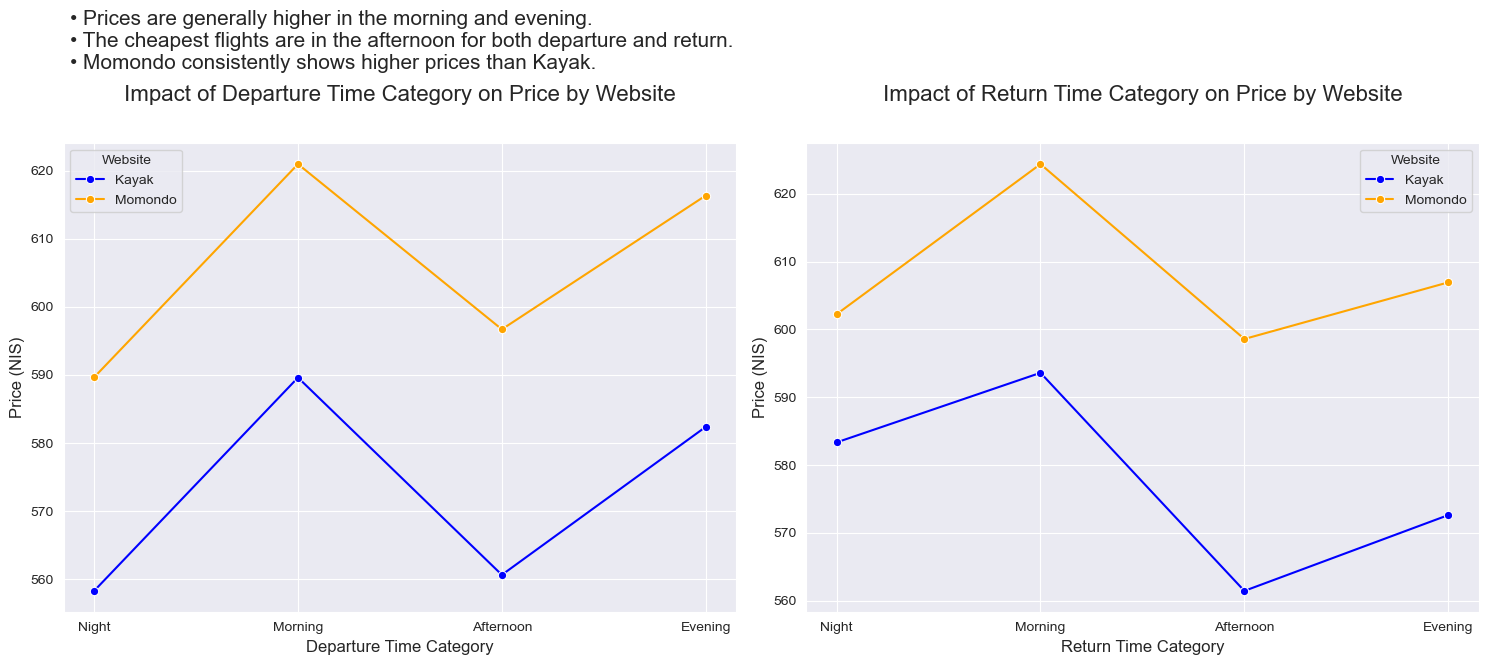

In [250]:

# Define category labels
time_categories = {0: "Night", 1: "Morning", 2: "Afternoon", 3: "Evening"}

# Create subplots for Departure and Return Time Category
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Departure Time Category plot
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="Departure Time Category Num", y="Price(NIS)", label="Kayak", 
             marker="o", color="blue", ax=axes[0], errorbar=None)
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="Departure Time Category Num", y="Price(NIS)", label="Momondo", 
             marker="o", color="orange", ax=axes[0], errorbar=None)

# Customize the first subplot
axes[0].set_title("Impact of Departure Time Category on Price by Website", fontsize=16, pad=30)
axes[0].set_xlabel("Departure Time Category", fontsize=12)
axes[0].set_ylabel("Price (NIS)", fontsize=12)
axes[0].set_xticks(list(time_categories.keys()))
axes[0].set_xticklabels(list(time_categories.values()))
axes[0].legend(title="Website")

# Return Time Category plot
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="Return Time Category Num", y="Price(NIS)", label="Kayak", 
             marker="o", color="blue", ax=axes[1], errorbar=None)
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="Return Time Category Num", y="Price(NIS)", label="Momondo", 
             marker="o", color="orange", ax=axes[1], errorbar=None)

# Customize the second subplot
axes[1].set_title("Impact of Return Time Category on Price by Website", fontsize=16, pad=30)
axes[1].set_xlabel("Return Time Category", fontsize=12)
axes[1].set_ylabel("Price (NIS)", fontsize=12)
axes[1].set_xticks(list(time_categories.keys()))
axes[1].set_xticklabels(list(time_categories.values()))
axes[1].legend(title="Website")

# Add conclusions above the plots
conclusions = (
    "• Prices are generally higher in the morning and evening.\n"
    "• The cheapest flights are in the afternoon for both departure and return.\n"
    "• Momondo consistently shows higher prices than Kayak."
)

# Adjust layout for conclusions
plt.subplots_adjust(top=1.2)
plt.figtext(0.05, 1.1, conclusions, fontsize=15, ha='left', va='top')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


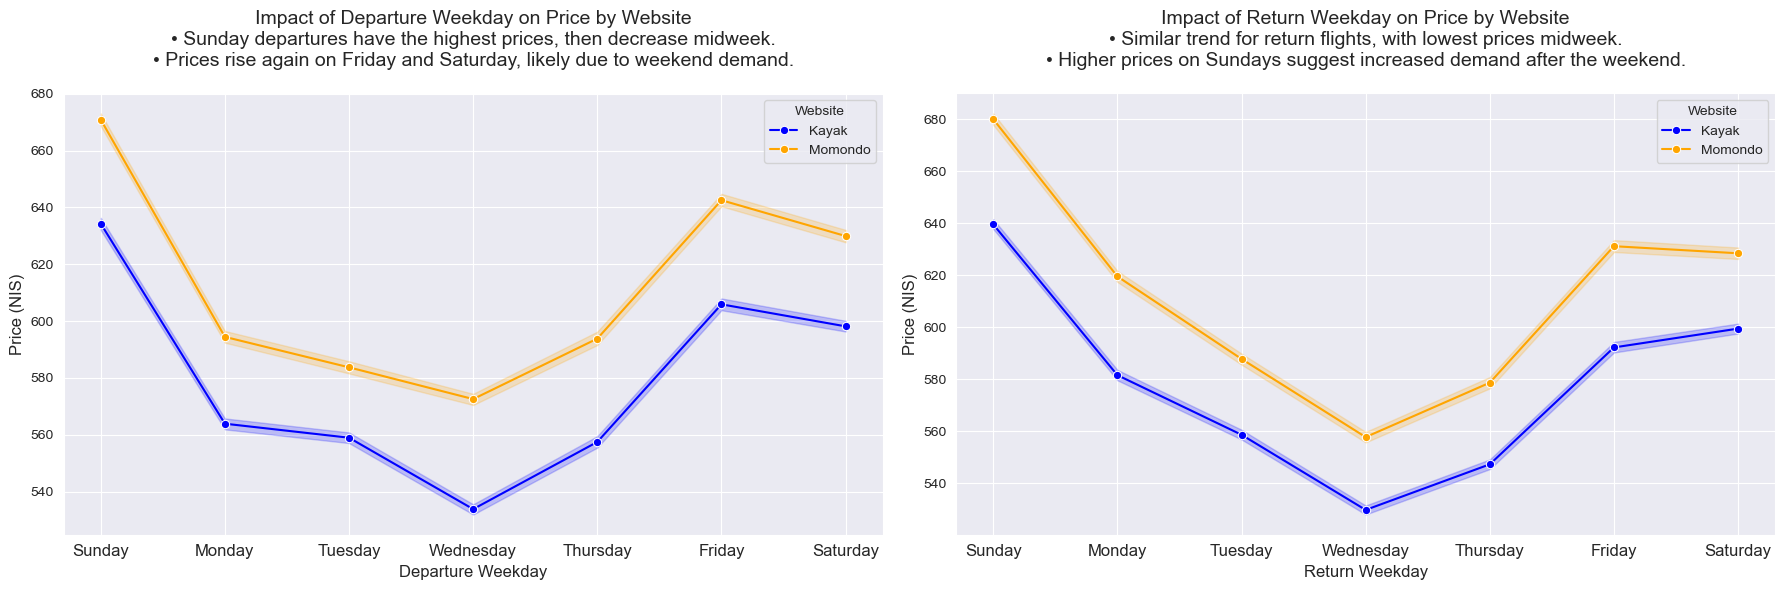

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping numbers to weekday names (starting from Sunday)
day_names = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 
             4: 'Thursday', 5: 'Friday', 6: 'Saturday'}

# Set figure size for both plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Line plot for Departure Weekday
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="Departure Weekday", y="Price(NIS)", label="Kayak", marker="o", color="blue", ax=axes[0])
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="Departure Weekday", y="Price(NIS)", label="Momondo", marker="o", color="orange", ax=axes[0])

# Line plot for Return Weekday
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="Return Weekday", y="Price(NIS)", label="Kayak", marker="o", color="blue", ax=axes[1])
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="Return Weekday", y="Price(NIS)", label="Momondo", marker="o", color="orange", ax=axes[1])

# Update x-axis to display weekdays instead of numbers
axes[0].set_xticks(range(7))
axes[0].set_xticklabels([day_names[i] for i in range(7)], fontsize=12)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels([day_names[i] for i in range(7)], fontsize=12)

# Add conclusions above the titles
departure_conclusions = (
    "• Sunday departures have the highest prices, then decrease midweek.\n"
    "• Prices rise again on Friday and Saturday, likely due to weekend demand."
)
return_conclusions = (
    "• Similar trend for return flights, with lowest prices midweek.\n"
    "• Higher prices on Sundays suggest increased demand after the weekend."
)

# Format plot titles with conclusions
axes[0].set_title(f"Impact of Departure Weekday on Price by Website\n{departure_conclusions}", fontsize=14, pad=20)
axes[1].set_title(f"Impact of Return Weekday on Price by Website\n{return_conclusions}", fontsize=14, pad=20)

# Set axis labels
axes[0].set_xlabel("Departure Weekday", fontsize=12)
axes[0].set_ylabel("Price (NIS)", fontsize=12)
axes[0].legend(title="Website")

axes[1].set_xlabel("Return Weekday", fontsize=12)
axes[1].set_ylabel("Price (NIS)", fontsize=12)
axes[1].legend(title="Website")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# **Price Differences Between Kayak and Momondo - Summary**

## **1️⃣ General Trends**
- Momondo is usually more expensive than Kayak, with greater price fluctuations.
- Kayak offers more stable pricing with fewer extreme variations.
- Significant price differences occur on weekends, during peak hours, and for flights with multiple connections.

---

## **2️⃣ Key Features Affecting Price Differences**
Below are the top 10 features with the strongest correlation to price differences:

### **🔼 Features Increasing Price Difference**
✔ **Return & Onward Airport Distances** – Longer distances lead to greater price gaps.  
✔ **Return Weekday** – The day of return slightly impacts price differences.  

### **🔽 Features Reducing Price Difference**
✔ **Departure & Return Days** – Some days have smaller price gaps.  
✔ **Length of Stay** – Longer stays slightly reduce price differences.  
✔ **Seasonal Effects** – Departure/return month has a minor role.  
✔ **Layover Duration** – Longer layovers tend to reduce price gaps.  

---

## **3️⃣ What Drives the Price Differences?**
📌 More connections increase prices, especially on Momondo.  
📌 Weekend flights (Friday-Sunday) are more expensive.  
📌 Morning and evening flights cost more, while afternoon flights are cheaper.  
📌 Long layovers may lead to lower price gaps.  
📌 Flight distance plays a major role in price differences.  

---

## **4️⃣ How This Helps Our Predictive Model**
🔹 Key features with high correlation will be used as predictors.  
🔹 Flight distance and timing variables will be prioritized.  
🔹 Categorical variables (weekends, time of day, layovers) will help capture non-linear effects.  
🔹 These insights guide feature selection and model choice for predicting price differences.  

---

## **📌 Key Takeaways**
✔ Momondo is usually more expensive, with greater fluctuations.  
✔ Kayak has more stable pricing, with fewer effects from layovers and stay duration.  
✔ Distance, layovers, and timing are major drivers of price differences.  
✔ These findings will help fine-tune our predictive model.  
